## Get env

+ v2:exp022 SGDする
+ v3:exp026 nanでるかも

In [1]:
#!nvidia-smi

In [2]:
# 環境によって処理を変えるためのもの
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

IN_COLAB:False, IN_KAGGLE:False, LOCAL:True


In [3]:
# For Colab Download some datasets
# ================================
if IN_COLAB:
    # mount googledrive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy kaggle.json from googledrive
    ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
    ! mkdir ~/.kaggle
    ! cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    
    if not os.path.exists("/content/input/"):
        !mkdir input
        !mkdir input/features
        !kaggle datasets download -d teyosan1229/ventilator-pressure
        !unzip /content/ventilator-pressure.zip -d input/features
        !kaggle competitions download -c ventilator-pressure-prediction
        !unzip /content/ventilator-pressure-prediction.zip -d input

In [4]:
if IN_KAGGLE or IN_COLAB:
    !pip install --upgrade -q wandb
    !pip install -q pytorch-lightning
    !pip install torch_optimizer

## Import Libraries

In [5]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
import pickle
from collections import defaultdict
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import RobustScaler, normalize, QuantileTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error #[roc_auc_score, accuracy_score]

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.optimizer import Optimizer, required
import torch_optimizer as optim

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, CSVLogger

# Weights and Biases Tool
import wandb
os.environ["WANDB_API_KEY"]='68fa1bbcda0fcf7a56f3c33a0fafa45b02f1c52d'
wandb.login()

wandb: Currently logged in as: teyosan1229 (use `wandb login --relogin` to force relogin)


True

## Config

In [6]:
class CFG:
    debug = False
    competition='ventilator'
    exp_name = "exp060"
    seed = 29
    # model
    # img_size = 384
    
    # data
    target_col = 'pressure' # 目標値のある列名
    target_size = 1
    
    # optimizer
    optimizer_name = 'RAdam'#['RAdam']sgd
    lr = 5e-3
    weight_decay = 1e-5
    amsgrad = False
    
    # scheduler
    epochs = 300
#     scheduler = 'CosineAnnealingLR' #['CosineAnnealingLR', 'ReduceLROnPlateau']
#     T_max = 300
#     min_lr = 1e-5
    
    scheduler = 'ReduceLROnPlateau' #['CosineAnnealingLR', 'ReduceLROnPlateau']
    factor = 0.5
    patience = 10
    eps = 1e-6
    # criterion
    # u_out = 1 を考慮しないLoss
    criterion_name = 'CustomLoss1'
    
    # training
    train = True
    inference = True
    n_fold = 10
    trn_fold = [0,1]
    precision = 16 #[16, 32, 64]
    grad_acc = 1
    # DataLoader
    loader = {
        "train": {
            "batch_size": 1024,
            "num_workers": 0,
            "shuffle": True,
            "pin_memory": True,
            "drop_last": True
        },
        "valid": {
            "batch_size": 1024,
            "num_workers": 0,
            "shuffle": False,
            "pin_memory": True,
            "drop_last": False
        }
    }
    # pl
    trainer = {
        'gpus': 1,
        'progress_bar_refresh_rate': 1,
        'benchmark': False,
        'deterministic': True,
        }
    # LSTM
    num_layers = 4
    # カテゴリ特徴量
    cate_cols = []

    # 連続値（スケーラー特徴用）
    cont_cols = []
    feature_cols = []
    dense_dim = 512
    hidden_size = 512
    logit_dim = 512
    
seed_everything(CFG.seed)
if not LOCAL:
    CFG.loader["train"]["num_workers"] = 4
    CFG.loader["valid"]["num_workers"] = 4

Global seed set to 29


In [7]:
len(CFG.feature_cols),CFG.loader["train"]["num_workers"]

(0, 0)

## Directory & LoadData

In [8]:
def get_cols_list(feats):
    cate_cols = []
    cont_cols = []
    if 'Base' in feats:
        cate_cols += ['u_out']
        cont_cols += ['time_step', 'u_in'] 
    if 'Area' in feats:
        cont_cols += ['time_delta','delta','area']
    if 'Cross' in feats:
        cont_cols += ['cross', 'cross2']
    if 'U_in_cumsum_mean' in feats:
        cont_cols += ['u_in_cumsum', 'u_in_cummean']
    if 'U_in_Lag' in feats:
        cont_cols += ['u_in_lag','u_in_lag2','u_in_lag3','u_in_lag4','u_in_lag_back','u_in_lag_back2','u_in_lag_back3','u_in_lag_back4']
    if 'U_out_Lag' in feats:
        cate_cols += ['u_out_lag','u_out_lag2','u_out_lag3','u_out_lag4','u_out_lag_back','u_out_lag_back2','u_out_lag_back3','u_out_lag_back4']
    if 'RC_OHE' in feats:
        cate_cols += ['R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50', 'RC_2010', 'RC_2020', 'RC_2050', 'RC_5010', 'RC_5020', 'RC_5050', 'RC_510', 'RC_520', 'RC_550']
    if 'U_out_stat' in feats:
        cont_cols += ['u_out0_mean', 'u_out0_max', 'u_out0_std', 'u_out1_mean', 'u_out1_max', 'u_out1_std']
    if 'U_in_Lag_Diff' in feats:
        cont_cols +=['u_in_lag1_diff', 'u_in_lag2_diff','u_in_lag3_diff', 'u_in_lag4_diff']
    if 'U_in_Rolling' in feats:
        cont_cols += ['u_in_rolling_mean2', 'u_in_rolling_mean4','u_in_rolling_mean10', 'u_in_rolling_max2', 'u_in_rolling_max4', 'u_in_rolling_max10',
                      'u_in_rolling_min2', 'u_in_rolling_min4', 'u_in_rolling_min10', 'u_in_rolling_std2', 'u_in_rolling_std4', 'u_in_rolling_std10']
    if 'U_in_delta' in feats:
        cont_cols += ['u_in_change', 'area_u_in_abs', 'uin_in_time']
    if 'Area_cumsum' in feats:
        cont_cols += ['area_cumsum']
    if 'U_in_stat' in feats:
        cont_cols += ['u_in_max', 'u_in_min','u_in_mean','u_in_std']
    if 'U_in_half_stat' in feats:
        cont_cols += ['u_in_half', 'u_in_half_max', 'u_in_half_min', 'u_in_half_mean', 'u_in_half_std']
    if 'U_in_first_last' in feats:
        cont_cols += ['u_in_first', 'u_in_last', 'time_end']
    return cate_cols, cont_cols

In [9]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/ventilator-pressure-prediction')
    FEAT_DIR = Path('../input/ventilator-pressure')
    OUTPUT_DIR = './'
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    FEAT_DIR = Path('/content/input/features/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/Ventilator Pressure/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/ventilator-pressure-prediction/data/input/")
    FEAT_DIR = Path("F:/Kaggle/ventilator-pressure-prediction/data/input/features/")
    OUTPUT_DIR = f'F:/Kaggle/ventilator-pressure-prediction/data/output/{CFG.exp_name}/'
    
def load_datasets(feats):
    dfs = [pd.read_feather(FEAT_DIR / f'{f}_train.ftr') for f in feats]
    X_train = pd.concat(dfs, axis=1)
    dfs = [pd.read_feather(FEAT_DIR / f'{f}_test.ftr') for f in feats]
    X_test = pd.concat(dfs, axis=1)
    return X_train, X_test

feats = ['Base', 
         'Area', 
         'Cross',
         'U_in_cumsum_mean', 
         'U_in_Lag', 
         #'U_out_Lag', 
         'RC_OHE', 
         'U_out_stat',
         'U_in_Lag_Diff',
         'U_in_Rolling',
         'U_in_delta',
         #'Area_cumsum',
         'U_in_stat',
         'U_in_half_stat',
         'U_in_first_last'
        ]
df_train, df_test = load_datasets(feats)
df_oof = df_train[["id","breath_id","u_out", "pressure", "fold"]].copy()

CFG.cate_cols, CFG.cont_cols = get_cols_list(feats)
CFG.feature_cols = CFG.cate_cols + CFG.cont_cols 

#df_train = pd.read_csv(INPUT_DIR / "train_v2.csv")
#df_test = pd.read_csv(INPUT_DIR / "test_v2.csv")
submission = pd.read_csv(INPUT_DIR / "sample_submission.csv")
display(df_train.head())
display(df_test.head())

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if CFG.debug:
    CFG.epochs = 5
    #CFG.inference = False
    #df_train = df_train.head(240000)

,id,breath_id,time_step,u_in,u_out,pressure,fold,time_delta,delta,area,...,u_in_mean,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end
0,1,1,0.000000,0.083334,0,5.837492,4,0.000000,0.000000,0.000000,...,10.146007,10.12367,0.083334,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
1,2,1,0.033652,18.383041,0,5.907794,4,0.033652,0.618632,0.618632,...,10.146007,10.12367,18.383041,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
2,3,1,0.067514,22.509278,0,7.876254,4,0.033862,0.762212,1.380843,...,10.146007,10.12367,22.509278,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
3,4,1,0.101542,22.808822,0,11.742872,4,0.034028,0.776134,2.156978,...,10.146007,10.12367,22.808822,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
4,5,1,0.135756,25.355850,0,12.234987,4,0.034213,0.867507,3.024485,...,10.146007,10.12367,25.355850,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766


,id,breath_id,time_step,u_in,u_out,time_delta,delta,area,cross,cross2,...,u_in_mean,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end
0,1,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,0.0,...,9.327338,12.179744,0.000000,37.542219,0.0,7.634534,13.031992,0.0,4.973375,2.519844
1,2,0,0.031904,7.515046,0,0.031904,0.239758,0.239758,0.0,0.0,...,9.327338,12.179744,7.515046,37.542219,0.0,7.634534,13.031992,0.0,4.973375,2.519844
2,3,0,0.063827,14.651675,0,0.031924,0.467733,0.707491,0.0,0.0,...,9.327338,12.179744,14.651675,37.542219,0.0,7.634534,13.031992,0.0,4.973375,2.519844
3,4,0,0.095751,21.230610,0,0.031924,0.677761,1.385252,0.0,0.0,...,9.327338,12.179744,21.230610,37.542219,0.0,7.634534,13.031992,0.0,4.973375,2.519844
4,5,0,0.127644,26.320956,0,0.031893,0.839442,2.224695,0.0,0.0,...,9.327338,12.179744,26.320956,37.542219,0.0,7.634534,13.031992,0.0,4.973375,2.519844


## Utils

In [10]:
# LINEに通知
import requests
def send_line_notification(message):
    env = ""
    if IN_COLAB: env = "colab"
    elif IN_KAGGLE: env = "kaggle"
    elif LOCAL: env = "local"
        
    line_token = '8vBbxd0jENU39kV2ROEwp78jAzeankBFi7AG0JjoU3j'
    endpoint = 'https://notify-api.line.me/api/notify'
    message = f"[{env}]{message}"
    payload = {'message': message}
    headers = {'Authorization': 'Bearer {}'.format(line_token)}
    requests.post(endpoint, data=payload, headers=headers)

## CV Split

In [11]:
# df_train["fold"] = -1
# Fold = GroupKFold(n_splits=CFG.n_fold)
# for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col], groups=df_train.breath_id.values)):
#      df_train.loc[val_index, 'fold'] = int(n)
# df_train['fold'] = df_train['fold'].astype(int)
# df_oof = df_train[["id","breath_id","u_out", "pressure", "fold"]].copy()
# print(df_train.groupby(['fold', 'breath_id']).size())

In [12]:
# 外からフォールドを取り込む
df_fold = pd.read_csv(INPUT_DIR / 'R_C_StratifiedKFold.csv')
df_train = df_train.drop('fold', axis=1).merge(df_fold[["breath_id", "fold"]], on="breath_id", how='left')
df_oof = df_train[["id","breath_id","u_out", "pressure", "fold"]].copy()
print(df_train.groupby(['fold', 'breath_id']).size())
del df_fold

fold  breath_id
0     2            80
      12           80
      14           80
      29           80
      37           80
                   ..
9     125687       80
      125688       80
      125717       80
      125722       80
      125737       80
Length: 75450, dtype: int64


## Transforms

## Dataset

In [13]:
"""
X[0]でbreath_id1つ分のシーケンス長80のデータを取得できる
"""
class TrainDataset(Dataset):
    def __init__(self, X, y, u_out):
        self.X = X
        self.y = y
        self.u_out = u_out
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.X[idx])
        u_out = torch.LongTensor(self.u_out[idx])
        label = torch.FloatTensor(self.y[idx]).squeeze(1)
        return x, u_out, label
    
class TestDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.u_out = self.X[:,:,2]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx])

## Rankgauss & Reshape
pandas.DataFrameからnumpyに変換、シーケンス分をまとめる

In [14]:
display(df_train[CFG.cate_cols].head())
display(df_train[CFG.cont_cols].head())

,u_out,R_20,R_5,R_50,C_10,C_20,C_50,RC_2010,RC_2020,RC_2050,RC_5010,RC_5020,RC_5050,RC_510,RC_520,RC_550
0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0


,time_step,u_in,time_delta,delta,area,cross,cross2,u_in_cumsum,u_in_cummean,u_in_lag,...,u_in_mean,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end
0,0.000000,0.083334,0.000000,0.000000,0.000000,0.0,0.0,0.083334,0.083334,0.000000,...,10.146007,10.12367,0.083334,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
1,0.033652,18.383041,0.033652,0.618632,0.618632,0.0,0.0,18.466375,9.233188,0.083334,...,10.146007,10.12367,18.383041,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
2,0.067514,22.509278,0.033862,0.762212,1.380843,0.0,0.0,40.975653,13.658551,18.383041,...,10.146007,10.12367,22.509278,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
3,0.101542,22.808822,0.034028,0.776134,2.156978,0.0,0.0,63.784476,15.946119,22.509278,...,10.146007,10.12367,22.808822,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766
4,0.135756,25.355850,0.034213,0.867507,3.024485,0.0,0.0,89.140326,17.828065,22.808822,...,10.146007,10.12367,25.355850,28.313036,0.0,8.294934,11.340418,0.083334,4.987079,2.689766


In [15]:
for col in tqdm(CFG.cont_cols):
#     qt = QuantileTransformer(random_state=0, output_distribution='normal')
#     df_train[[col]] = qt.fit_transform(df_train[[col]])
#     df_test[[col]] = qt.transform(df_test[[col]])
    rs = RobustScaler()
    df_train[[col]] = rs.fit_transform(df_train[[col]])
    df_test[[col]] = rs.transform(df_test[[col]])
display(df_train.head())
display(df_test.head())
df_train.describe().T.to_csv(OUTPUT_DIR + '/' + "describe.csv")

  0%|          | 0/54 [00:00<?, ?it/s]

,id,breath_id,time_step,u_in,u_out,pressure,time_delta,delta,area,cross,...,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end,fold
0,1,1,-0.989052,-0.937384,0,5.837492,-15.475938,-0.860663,-0.734997,0.0,...,0.443556,0.022076,0.112313,0.0,0.949367,0.481111,-0.137993,0.631103,0.2076,8
1,2,1,-0.963608,3.049278,0,5.907794,0.103311,2.863270,-0.683536,0.0,...,0.443556,4.869815,0.112313,0.0,0.949367,0.481111,-0.137993,0.631103,0.2076,8
2,3,1,-0.938006,3.948195,0,7.876254,0.200442,3.727568,-0.620131,0.0,...,0.443556,5.962888,0.112313,0.0,0.949367,0.481111,-0.137993,0.631103,0.2076,8
3,4,1,-0.912278,4.013452,0,11.742872,0.277152,3.811377,-0.555568,0.0,...,0.443556,6.042239,0.112313,0.0,0.949367,0.481111,-0.137993,0.631103,0.2076,8
4,5,1,-0.886409,4.568332,0,12.234987,0.363024,4.361409,-0.483405,0.0,...,0.443556,6.716967,0.112313,0.0,0.949367,0.481111,-0.137993,0.631103,0.2076,8


,id,breath_id,time_step,u_in,u_out,time_delta,delta,area,cross,cross2,...,u_in_mean,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end
0,1,0,-0.989052,-0.955539,0,-15.475938,-0.860663,-0.734997,0.0,-0.665541,...,0.749398,0.648469,0.000000,0.334769,0.0,0.814995,0.645258,-0.143908,-0.128746,-0.814627
1,2,0,-0.964930,0.681643,0,-0.706181,0.582592,-0.715053,0.0,-0.665541,...,0.749398,0.648469,1.990796,0.334769,0.0,0.814995,0.645258,-0.143908,-0.128746,-0.814627
2,3,0,-0.940793,2.236385,0,-0.697020,1.954917,-0.676144,0.0,-0.665541,...,0.749398,0.648469,3.881346,0.334769,0.0,0.814995,0.645258,-0.143908,-0.128746,-0.814627
3,4,0,-0.916656,3.669632,0,-0.696909,3.219207,-0.619765,0.0,-0.665541,...,0.749398,0.648469,5.624158,0.334769,0.0,0.814995,0.645258,-0.143908,-0.128746,-0.814627
4,5,0,-0.892543,4.778584,0,-0.711369,4.192466,-0.549935,0.0,-0.665541,...,0.749398,0.648469,6.972632,0.334769,0.0,0.814995,0.645258,-0.143908,-0.128746,-0.814627


In [16]:
for col in tqdm(CFG.cont_cols):
    ss = StandardScaler()
    df_train[[col]] = ss.fit_transform(df_train[[col]])
    df_test[[col]] = ss.transform(df_test[[col]])
display(df_train.head())
display(df_test.head())
df_train.describe().T.to_csv(OUTPUT_DIR + '/' + "describe_ss.csv")

  0%|          | 0/54 [00:00<?, ?it/s]

,id,breath_id,time_step,u_in,u_out,pressure,time_delta,delta,area,cross,...,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end,fold
0,1,1,-1.706609,-0.538775,0,5.837492,-8.432443,-0.544429,-0.973240,-0.649194,...,0.119327,-0.390070,-0.240724,0.0,0.512198,0.203407,-0.55008,0.281162,0.860642,8
1,2,1,-1.662676,0.823348,0,5.907794,0.249547,0.878579,-0.926881,-0.649194,...,0.119327,0.928361,-0.240724,0.0,0.512198,0.203407,-0.55008,0.281162,0.860642,8
2,3,1,-1.618468,1.130480,0,7.876254,0.303675,1.208849,-0.869763,-0.649194,...,0.119327,1.225642,-0.240724,0.0,0.512198,0.203407,-0.55008,0.281162,0.860642,8
3,4,1,-1.574044,1.152777,0,11.742872,0.346425,1.240874,-0.811601,-0.649194,...,0.119327,1.247223,-0.240724,0.0,0.512198,0.203407,-0.55008,0.281162,0.860642,8
4,5,1,-1.529378,1.342362,0,12.234987,0.394279,1.451055,-0.746593,-0.649194,...,0.119327,1.430727,-0.240724,0.0,0.512198,0.203407,-0.55008,0.281162,0.860642,8


,id,breath_id,time_step,u_in,u_out,time_delta,delta,area,cross,cross2,...,u_in_mean,u_in_std,u_in_half,u_in_half_max,u_in_half_min,u_in_half_mean,u_in_half_std,u_in_first,u_in_last,time_end
0,1,0,-1.706609,-0.544978,0,-8.432443,-0.544429,-0.973240,-0.649194,-1.175193,...,0.364698,0.367378,-0.396074,0.052025,0.0,0.391282,0.401965,-0.553396,0.267353,-1.090211
1,2,0,-1.664958,0.014398,0,-0.201566,0.007075,-0.955273,-0.649194,-1.175193,...,0.364698,0.367378,0.145359,0.052025,0.0,0.391282,0.401965,-0.553396,0.267353,-1.090211
2,3,0,-1.623282,0.545607,0,-0.196461,0.531474,-0.920222,-0.649194,-1.175193,...,0.364698,0.367378,0.659529,0.052025,0.0,0.391282,0.401965,-0.553396,0.267353,-1.090211
3,4,0,-1.581604,1.035304,0,-0.196400,1.014591,-0.869433,-0.649194,-1.175193,...,0.364698,0.367378,1.133518,0.052025,0.0,0.391282,0.401965,-0.553396,0.267353,-1.090211
4,5,0,-1.539968,1.414199,0,-0.204457,1.386498,-0.806527,-0.649194,-1.175193,...,0.364698,0.367378,1.500260,0.052025,0.0,0.391282,0.401965,-0.553396,0.267353,-1.090211


In [17]:
X = np.float32(df_train[CFG.feature_cols]).reshape(-1, 80, len(CFG.feature_cols))
U_out = np.float32(df_train[["u_out"]]).reshape(-1, 80)
test_X = np.float32(df_test[CFG.feature_cols]).reshape(-1, 80, len(CFG.feature_cols))
y = np.float32(df_train["pressure"]).reshape(-1, 80, 1)
Fold = np.int16(df_train["fold"]).reshape(-1, 80, 1)
Fold = Fold.mean(axis=1).flatten()
print(X.shape, U_out.shape, y.shape, test_X.shape, Fold.shape)

(75450, 80, 70) (75450, 80) (75450, 80, 1) (50300, 80, 70) (75450,)


In [18]:
# X, u_out, y になっているか確認
ds = TrainDataset(X,y, U_out)
for i in range(3):
    print("="*50)
    print(ds[0][i])
del ds

tensor([[ 0.0000,  1.0000,  0.0000,  ..., -0.5501,  0.2812,  0.8606],
        [ 0.0000,  1.0000,  0.0000,  ..., -0.5501,  0.2812,  0.8606],
        [ 0.0000,  1.0000,  0.0000,  ..., -0.5501,  0.2812,  0.8606],
        ...,
        [ 1.0000,  1.0000,  0.0000,  ..., -0.5501,  0.2812,  0.8606],
        [ 1.0000,  1.0000,  0.0000,  ..., -0.5501,  0.2812,  0.8606],
        [ 1.0000,  1.0000,  0.0000,  ..., -0.5501,  0.2812,  0.8606]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 5.8375,  5.9078,  7.8763, 11.7429, 12.2350, 12.8677, 14.6956, 15.8907,
        15.5392, 15.7501, 17.2967, 17.2264, 16.1719, 17.3670, 18.0701, 17.1561,
        18.2810, 18.7731, 17.8592, 19.1246, 19.3355, 18.4919, 18.5622, 18.6325,
        18.8434, 19.0543, 19.2652, 19.3355, 19.3355, 

In [19]:
X[Fold!=0].shape,U_out[Fold!=0].shape

((67905, 80, 70), (67905, 80))

## DataModule

In [20]:
class DataModule(pl.LightningDataModule):
    """
    numpy arrayで受け取る
    """
    def __init__(self, tr_X, tr_y, tr_u_out,
                 val_X, val_y, val_u_out,
                 test_X, cfg):
        super().__init__()
        self.train_data = tr_X
        self.train_label = tr_y
        self.train_u_out = tr_u_out
        self.valid_data = val_X
        self.valid_label = val_y
        self.valid_u_out = val_u_out
        self.test_data = test_X
        self.cfg = cfg
        
    def setup(self, stage=None):
        self.train_dataset = TrainDataset(self.train_data, self.train_label, self.train_u_out)
        self.valid_dataset = TrainDataset(self.valid_data, self.valid_label, self.valid_u_out)
        self.test_dataset = TestDataset(self.test_data)
        
    # Trainer.fit() 時に呼び出される
    def train_dataloader(self):
        return DataLoader(self.train_dataset, **self.cfg.loader['train'])

    # Trainer.fit() 時に呼び出される
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, **self.cfg.loader['valid'])

    def test_dataloader(self):
        return DataLoader(self.test_dataset, **self.cfg.loader['valid'])

In [21]:
# Data = DataModule(X[Fold==0],y[Fold==0],X[Fold==1],y[Fold==1],X[Fold==2], CFG)
# Data.setup()
# loader = Data.train_dataloader()
# tmp = loader.__iter__()
# print(tmp.next())
# del Data, loader, tmp

## Pytorch Lightning Module

In [22]:
# ====================================================
# model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg):
        hidden = [400, 300, 200, 100]
        super().__init__()
        self.cfg = cfg
        self.lstm1 = nn.LSTM(len(cfg.feature_cols), hidden[0],
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hidden[0], hidden[1],
                             batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hidden[1], hidden[2],
                             batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(2 * hidden[2], hidden[3],
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden[3], 50)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(50, 1)
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        bs = x.size(0)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc1(x)
        x = self.selu(x)
        output = self.fc2(x).view(bs, -1)
        #output = self.head(features).view(bs, -1)
        return output
    
def get_model(cfg):
    model = CustomModel(cfg)
    return model

# ====================================================
# criterion
# ====================================================
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """
    
    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    
    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

def get_criterion():
    if CFG.criterion_name == 'BCEWithLogitsLoss':
        # plだとto(device)いらない
        criterion = nn.BCEWithLogitsLoss(reduction="mean")
    if CFG.criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    if CFG.criterion_name == 'CustomLoss1':
        # [reference]https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm
        criterion = VentilatorLoss()
    else:
        raise NotImplementedError
    return criterion
# ====================================================
# optimizer
# ====================================================
def get_optimizer(model: nn.Module, config: dict):
    """
    input:
    model:model
    config:optimizer_nameやlrが入ったものを渡す
    
    output:optimizer
    """
    optimizer_name = config.optimizer_name
    if 'Adam' == optimizer_name:
        return Adam(model.parameters(),
                    lr=config.lr,
                    weight_decay=config.weight_decay,
                    amsgrad=config.amsgrad)
    elif 'RAdam' == optimizer_name:
        return optim.RAdam(model.parameters(),
                           lr=config.lr,
                           weight_decay=config.weight_decay)
    elif 'sgd' == optimizer_name:
        return SGD(model.parameters(),
                   lr=config.lr,
                   momentum=0.9,
                   nesterov=True,
                   weight_decay=config.weight_decay,)
    else:
        raise NotImplementedError

# ====================================================
# scheduler
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        """
        factor : 学習率の減衰率
        patience : 何ステップ向上しなければ減衰するかの値
        eps : nanとかInf回避用の微小数
        """
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        """
        T_max : 1 半周期のステップサイズ
        eta_min : 最小学習率(極小値)
        """
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        """
        T_0 : 初期の繰りかえし回数
        T_mult : サイクルのスケール倍率
        """
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    else:
        raise NotImplementedError
    return scheduler

In [23]:
# # modelの動作確認
# model = get_model(CFG)
# Data = DataModule(df_train,df_train,df_train, CFG)
# Data.setup()
# loader = Data.train_dataloader()
# tmp = loader.__iter__()
# x, u_out, label = tmp.next()
# print(x.shape, u_out.shape, label.shape)
# output = model(x)
# print(output.shape)
# del model, Data, loader, tmp,x, u_out, label, output

In [24]:
# #schedulerの確認
# model = get_model(CFG)
# optimizer = get_optimizer(model, CFG)
# scheduler = get_scheduler(optimizer)
# from pylab import rcParams
# lrs = []
# for epoch in range(1, CFG.epochs+1):
#     scheduler.step(epoch-1)
#     lrs.append(optimizer.param_groups[0]["lr"])
# rcParams['figure.figsize'] = 20,3
# print(lrs)
# plt.plot(lrs)

In [25]:
class Trainer(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.model = get_model(cfg)
        self.criterion = get_criterion()
    
    def forward(self, x):
        output = self.model(x)
        return output
    
    def training_step(self, batch, batch_idx):
        x, u_out, y = batch
        # mixup とかしたい場合はここに差し込む
        output = self.forward(x)
        labels = y#.unsqueeze(1)
        loss = self.criterion(output, labels ,u_out).mean()
        
        #self.log_dict(dict(train_loss=loss))
        self.log('train_loss', loss, on_step=True, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}
    
    def training_epoch_end(self, outputs):
        loss = 0
        for output in outputs:
            loss += output['loss']
        loss = loss/len(outputs)
        self.log('train_loss_epoch', loss, logger=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'], prog_bar=True, logger=True)
    
    def validation_step(self, batch, batch_idx):
        x, u_out, y = batch
        output = self.forward(x)
        labels = y#.unsqueeze(1)
        loss = self.criterion(output,labels ,u_out).mean()
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {"predictions": output,
                "labels": labels,
                "loss": loss.item()}
    
    def validation_epoch_end(self, outputs):
        preds = []
        labels = []
        loss = 0
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']
            loss += output['loss']

        labels = torch.stack(labels)
        preds = torch.stack(preds)
        loss = loss/len(outputs)
        
        self.log("val_loss_epoch", loss, prog_bar=True, logger=True)
        
    def predict_step(self, batch, batch_idx):
        x = batch
        output = self.forward(x)
        return output
        
    def test_step(self, batch, batch_idx):
        x = batch       
        output = self.forward(x)
        return output
    
    def configure_optimizers(self):
        self.optimizer = get_optimizer(self, self.cfg)
        self.scheduler = {'scheduler': get_scheduler(self.optimizer),
                          "monitor": "val_loss_epoch",
                          'interval': 'epoch', # 'step'or 'epoch'
                          'frequency': 1}
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

## Train

In [26]:
def train() -> None:
    for fold in range(CFG.n_fold):
        if not fold in CFG.trn_fold:
            continue
        print(f"{'='*38} Fold: {fold} {'='*38}")
        # Logger
        #======================================================
        lr_monitor = LearningRateMonitor(logging_interval='step')
        # 学習済重みを保存するために必要
        loss_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_loss_fold{fold}",
            monitor="val_loss_epoch",
            save_last=True,
            save_top_k=1,
            save_weights_only=True,
            mode="min",
        )
        csv_logger = CSVLogger(save_dir=str(OUTPUT_DIR), name=f"fold_{fold}")
        wandb_logger = WandbLogger(
            project=f'{CFG.competition}',
            group= f'{CFG.exp_name}',
            name = f'Fold{fold}',
            save_dir=OUTPUT_DIR
        )
        data_module = DataModule(X[Fold!=fold], y[Fold!=fold],U_out[Fold!=fold],
                                 X[Fold==fold], y[Fold==fold],U_out[Fold==fold],
                                 test_X,
                                 CFG
                                )
        data_module.setup()
        
        CFG.T_max = int(math.ceil(len(data_module.train_dataloader())/CFG.grad_acc)*CFG.epochs)
        print(f"set schedular T_max {CFG.T_max}")
        early_stopping_callback = EarlyStopping(monitor='val_loss_epoch', mode="min", patience=60)
        
        trainer = pl.Trainer(
            logger=[csv_logger,wandb_logger],
            callbacks=[loss_checkpoint, early_stopping_callback],#lr_monitor,early_stopping_callback
            default_root_dir=OUTPUT_DIR,
            accumulate_grad_batches=CFG.grad_acc,
            max_epochs=CFG.epochs,
            precision=CFG.precision,
            **CFG.trainer
        )
        # 学習
        model = Trainer(CFG)
        trainer.fit(model, data_module)
        torch.save(model.model.state_dict(),OUTPUT_DIR + '/' + f'{CFG.exp_name}_fold{fold}.pth')
        
        del model, data_module
        # テストデータを予測して保存
        if CFG.inference:
            data_module = DataModule(X[0:1], y[0:1],U_out[0:1], X[0:1], y[0:1],U_out[0:1], test_X, CFG)
            data_module.setup()
            # best loss modelのロード
            best_model = Trainer.load_from_checkpoint(cfg=CFG,checkpoint_path=loss_checkpoint.best_model_path)
            predictions = trainer.predict(best_model, data_module.test_dataloader())
            preds = []
            for p in predictions:
                preds += p
            preds = torch.stack(preds).flatten()
            submission['pressure'] = preds.to('cpu').detach().numpy()
            submission.to_csv(OUTPUT_DIR + '/' + f'submission_fold{fold}.csv',index=False)
            
            # oof
            data_module = DataModule(X[0:1], y[0:1],U_out[0:1], X[0:1], y[0:1],U_out[0:1], X[Fold==fold], CFG)
            data_module.setup()
            predictions = trainer.predict(best_model, data_module.test_dataloader())
            preds = []
            for p in predictions:
                preds += p
            preds = torch.stack(preds).flatten()
            df_oof.loc[df_oof["fold"] == fold, ['pred']] = preds.to('cpu').detach().numpy()
            df_oof.to_csv(OUTPUT_DIR + '/' + f'oof.csv',index=False)
        
        wandb.finish()

        

In [27]:
train()
send_line_notification("finished")
wandb.finish()


====================================== Fold: 0 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


set schedular T_max 19800


D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 5.9 M 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.400    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:398: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    77: reducing learning rate of group 0 to 2.5000e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    92: reducing learning rate of group 0 to 1.2500e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   147: reducing learning rate of group 0 to 6.2500e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   171: reducing learning rate of group 0 to 3.1250e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   196: reducing learning rate of group 0 to 1.5625e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   227: reducing learning rate of group 0 to 7.8125e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   238: reducing learning rate of group 0 to 3.9063e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   249: reducing learning rate of group 0 to 1.9531e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   260: reducing learning rate of group 0 to 9.7656e-06.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   271: reducing learning rate of group 0 to 4.8828e-06.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 66it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 66it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


train_loss,0.05115
epoch,275
trainer/global_step,18215
_step,3123
_runtime,2421
_timestamp,1634988984
val_loss_step,0.19087
val_loss_epoch,0.17364
train_loss_epoch,0.0512
lr,0.0


train_loss,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▁▁▁▂▁▃▁▁▁▁▄▁▄▁▁▅▁▅▁▁▂▂▂▂▆▂▂▂▂▂▂█▂█▂▂
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_step,█▆▅▃▃▄▃▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_epoch,█▆▅▃▃▄▃▃▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▆▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


====================================== Fold: 1 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


set schedular T_max 19800


wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 5.9 M 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.400    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    83: reducing learning rate of group 0 to 2.5000e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    98: reducing learning rate of group 0 to 1.2500e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   128: reducing learning rate of group 0 to 6.2500e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   144: reducing learning rate of group 0 to 3.1250e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   170: reducing learning rate of group 0 to 1.5625e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   207: reducing learning rate of group 0 to 7.8125e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   225: reducing learning rate of group 0 to 3.9063e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   236: reducing learning rate of group 0 to 1.9531e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   247: reducing learning rate of group 0 to 9.7656e-06.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   258: reducing learning rate of group 0 to 4.8828e-06.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch   269: reducing learning rate of group 0 to 2.4414e-06.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 66it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 66it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


train_loss,0.05909
epoch,273
trainer/global_step,18083
_step,3100
_runtime,2471
_timestamp,1634991483
val_loss_step,0.14847
val_loss_epoch,0.1671
train_loss_epoch,0.05831
lr,0.0


train_loss,█▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁▅▁▅▁▁▂▂▆▂▆▂▂▇▂▇▂▇▂▂█▂
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_step,█▆▅▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_epoch,█▆▅▃▃▃▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████████████▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [28]:
oof = pd.read_csv(OUTPUT_DIR + 'oof.csv')
cv = compute_metric(oof,oof["pred"])
print(f"cv:{cv}")

cv:0.034220282222673044


In [29]:
# # median
submission = pd.read_csv(INPUT_DIR / "sample_submission.csv")
n_fold = 10
preds = [pd.read_csv(f'F:/Kaggle/ventilator-pressure-prediction/data/output/{CFG.exp_name}/submission_fold{i}.csv') for i in range(n_fold)]
#print(preds[0].pressure[0],preds[1].pressure[0],preds[2].pressure[0],preds[3].pressure[0],preds[4].pressure[0])
submission['pressure'] = np.median([i.pressure for i in preds],axis=0)
submission.to_csv(f'F:/Kaggle/ventilator-pressure-prediction/data/output/{CFG.exp_name}/{CFG.exp_name}_{n_fold}fold_median.csv',index=False)
submission.head()

FileNotFoundError: [Errno 2] No such file or directory: 'F:/Kaggle/ventilator-pressure-prediction/data/output/exp060/submission_fold2.csv'

In [ ]:

submission

In [30]:
# LSTM Feature Importance
print(' Computing LSTM feature importance...')
fold_num = 0
checkpoint_path = f"F:/Kaggle/ventilator-pressure-prediction/data/output/{CFG.exp_name}/best_loss_fold{fold_num}.ckpt"
best_model = Trainer.load_from_checkpoint(cfg=CFG, checkpoint_path=checkpoint_path)
trainer = pl.Trainer(
            default_root_dir=OUTPUT_DIR,
            accumulate_grad_batches=CFG.grad_acc,
            max_epochs=CFG.epochs,
            precision=CFG.precision,
            **CFG.trainer
        )
def flatten_predictions(predictions):
    preds = []
    for p in predictions:
        preds += p
    return torch.stack(preds).flatten().to('cpu').detach().numpy()


X_valid = X[Fold==fold_num]
y_valid = df_train.loc[df_train["fold"] == fold_num, ["u_out","pressure"]].copy()
data_module = DataModule(X[0:1], y[0:1],U_out[0:1], X[0:1], y[0:1],U_out[0:1], X_valid, CFG)
data_module.setup()
predictions = trainer.predict(best_model, data_module.test_dataloader())
preds = flatten_predictions(predictions)
baseline_mae = compute_metric(y_valid,preds)

results = []
for k in tqdm(range(len(CFG.feature_cols))):
    # SHUFFLE FEATURE K
    save_col = X_valid[:,:,k].copy()
    np.random.shuffle(X_valid[:,:,k])
    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    data_module = DataModule(X[0:1], y[0:1],U_out[0:1], X[0:1], y[0:1],U_out[0:1], X_valid, CFG)
    data_module.setup()
    predictions = trainer.predict(best_model, data_module.test_dataloader())
    preds = flatten_predictions(predictions)
    cv = compute_metric(y_valid,preds)
    results.append({'feature':CFG.feature_cols[k],'mae':cv})
    X_valid[:,:,k] = save_col

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


 Computing LSTM feature importance...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

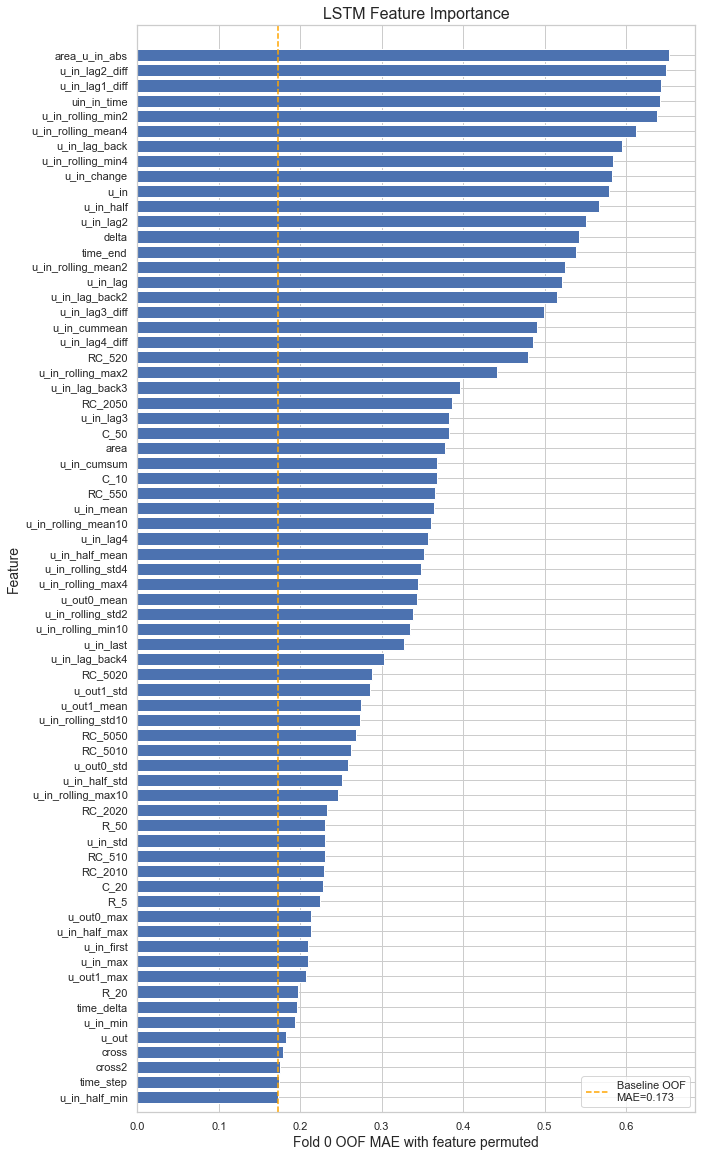

In [31]:
# DISPLAY LSTM FEATURE IMPORTANCE
print()
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,20))
plt.barh(np.arange(len(CFG.feature_cols)),df.mae)
plt.yticks(np.arange(len(CFG.feature_cols)),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(CFG.feature_cols)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(CFG.feature_cols)+1], '--', color='orange',
         label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
plt.xlabel(f'Fold {fold_num} OOF MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [ ]:
df